In [1]:
import csv
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split

RANDOM_SEED = 42

2025-04-27 14:20:34.009320: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 14:20:34.054577: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-27 14:20:34.055406: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-27 14:20:35.039788: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Path Specifications

In [2]:
base_path = '/home/yunusdanabas/catkin_ws/src/hand_steer_sim'

In [3]:
dataset = f'{base_path}/hand_steer_sim/model/steering_mode/point_history_classifier/point_history.csv'
model_save_path = f'{base_path}/hand_steer_sim/model/steering_mode/point_history_classifier/point_history_classifier.hdf5'
tflite_save_path = f'{base_path}/hand_steer_sim/model/steering_mode/point_history_classifier/point_history_classifier.tflite'

# Number of Classes Setting

In [4]:
NUM_CLASSES = 5

# Input Length

In [5]:
TIME_STEPS = 16
DIMENSION = 2

# Loading Training Data

In [6]:
X_dataset = np.loadtxt(dataset, delimiter=',', dtype='float32', usecols=list(range(1, (TIME_STEPS * DIMENSION) + 1)))

In [7]:
y_dataset = np.loadtxt(dataset, delimiter=',', dtype='int32', usecols=(0))

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X_dataset, y_dataset, train_size=0.75, random_state=RANDOM_SEED)

# Model Construction

In [9]:
use_lstm = False
model = None

if use_lstm:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Reshape((TIME_STEPS, DIMENSION), input_shape=(TIME_STEPS * DIMENSION, )), 
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.LSTM(16, input_shape=[TIME_STEPS, DIMENSION]),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])
else:
    model = tf.keras.models.Sequential([
        tf.keras.layers.InputLayer(input_shape=(TIME_STEPS * DIMENSION, )),
        tf.keras.layers.Dropout(0.2),
        tf.keras.layers.Dense(24, activation='relu'),
        tf.keras.layers.Dropout(0.5),
        tf.keras.layers.Dense(10, activation='relu'),
        tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')
    ])

In [10]:
model.summary()  # tf.keras.utils.plot_model(model, show_shapes=True)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense (Dense)               (None, 24)                792       
                                                                 
 dropout_1 (Dropout)         (None, 24)                0         
                                                                 
 dense_1 (Dense)             (None, 10)                250       
                                                                 
 dense_2 (Dense)             (None, 5)                 55        
                                                                 
Total params: 1097 (4.29 KB)
Trainable params: 1097 (4.29 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
# Model Checkpoint Callback
cp_callback = tf.keras.callbacks.ModelCheckpoint(
    model_save_path, verbose=1, save_weights_only=False)
# Early Stopping Callback
es_callback = tf.keras.callbacks.EarlyStopping(patience=20, verbose=1)

In [12]:
# Model Compilation
model.compile(
    optimizer='adam',
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

# Model Training

In [13]:
model.fit(
    X_train,
    y_train,
    epochs=1000,
    batch_size=128,
    validation_data=(X_test, y_test),
    callbacks=[cp_callback, es_callback]
)

Epoch 1/1000
24/24 [==============================] - ETA: 0s - loss: 1.5936 - accuracy: 0.5140 
Epoch 1: saving model to /home/yunusdanabas/catkin_ws/src/hand_steer_sim/hand_steer_sim/model/steering_mode/point_history_classifier/point_history_classifier.hdf5
24/24 [==============================] - 2s 27ms/step - loss: 1.5936 - accuracy: 0.5140 - val_loss: 1.5571 - val_accuracy: 0.6983
Epoch 2/1000
17/24 [====================>.........] - ETA: 0s - loss: 1.5510 - accuracy: 0.6062
Epoch 2: saving model to /home/yunusdanabas/catkin_ws/src/hand_steer_sim/hand_steer_sim/model/steering_mode/point_history_classifier/point_history_classifier.hdf5
24/24 [==============================] - 0s 6ms/step - loss: 1.5430 - accuracy: 0.6097 - val_loss: 1.4976 - val_accuracy: 0.6944
Epoch 3/1000
 1/24 [>.............................] - ETA: 0s - loss: 1.5188 - accuracy: 0.5938

/home/yunusdanabas/mambaforge/envs/ros_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/24 [==============================] - ETA: 0s - loss: 1.4821 - accuracy: 0.6206
Epoch 3: saving model to /home/yunusdanabas/catkin_ws/src/hand_steer_sim/hand_steer_sim/model/steering_mode/point_history_classifier/point_history_classifier.hdf5
24/24 [==============================] - 0s 5ms/step - loss: 1.4821 - accuracy: 0.6206 - val_loss: 1.4248 - val_accuracy: 0.6954
Epoch 4/1000
16/24 [===================>..........] - ETA: 0s - loss: 1.4210 - accuracy: 0.6230
Epoch 4: saving model to /home/yunusdanabas/catkin_ws/src/hand_steer_sim/hand_steer_sim/model/steering_mode/point_history_classifier/point_history_classifier.hdf5
24/24 [==============================] - 0s 7ms/step - loss: 1.4087 - accuracy: 0.6199 - val_loss: 1.3313 - val_accuracy: 0.6924
Epoch 5/1000
14/24 [================>.............] - ETA: 0s - loss: 1.3407 - accuracy: 0.6239
Epoch 5: saving model to /home/yunusdanabas/catkin_ws/src/hand_steer_sim/hand_steer_sim/model/steering_mode/point_history_classifier/point_hi

In [14]:
# Load the Saved Model
model = tf.keras.models.load_model(model_save_path)

In [15]:
# Inference Test
predict_result = model.predict(np.array([X_test[0]]))
print(np.squeeze(predict_result))
print(np.argmax(np.squeeze(predict_result)))

1/1 [==============================] - 0s 74ms/step
[1.5596474e-17 1.3577743e-01 5.6264591e-01 2.9277268e-01 8.8039013e-03]
2


# Confusion Matrix

32/32 [==============================] - 0s 795us/step


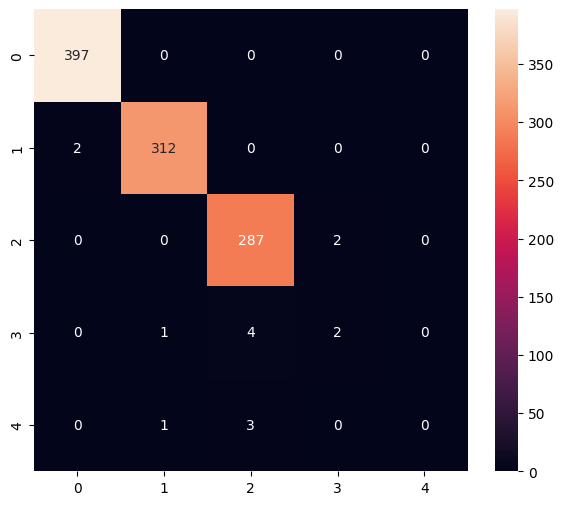

Classification Report
              precision    recall  f1-score   support

           0       0.99      1.00      1.00       397
           1       0.99      0.99      0.99       314
           2       0.98      0.99      0.98       289
           3       0.50      0.29      0.36         7
           4       0.00      0.00      0.00         4

    accuracy                           0.99      1011
   macro avg       0.69      0.65      0.67      1011
weighted avg       0.98      0.99      0.98      1011



/home/yunusdanabas/mambaforge/envs/ros_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yunusdanabas/mambaforge/envs/ros_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/yunusdanabas/mambaforge/envs/ros_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modif

In [16]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report

def print_confusion_matrix(y_true, y_pred, report=True):
    labels = sorted(list(set(y_true)))
    cmx_data = confusion_matrix(y_true, y_pred, labels=labels)
    
    df_cmx = pd.DataFrame(cmx_data, index=labels, columns=labels)
 
    fig, ax = plt.subplots(figsize=(7, 6))
    sns.heatmap(df_cmx, annot=True, fmt='g' ,square=False)
    ax.set_ylim(len(set(y_true)), 0)
    plt.show()
    
    if report:
        print('Classification Report')
        print(classification_report(y_test, y_pred))

Y_pred = model.predict(X_test)
y_pred = np.argmax(Y_pred, axis=1)

print_confusion_matrix(y_test, y_pred)

# Convert to TensorFlow Lite Model

In [17]:
# Save as an Inference-Only Model
model.save(model_save_path, include_optimizer=False)
model = tf.keras.models.load_model(model_save_path)

/home/yunusdanabas/mambaforge/envs/ros_env/lib/python3.8/site-packages/keras/src/engine/training.py:3000: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [18]:
# Convert Model (Quantization)
converter = tf.lite.TFLiteConverter.from_keras_model(model)  # converter = tf.lite.TFLiteConverter.from_saved_model(saved_model_path)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
tflite_quantized_model = converter.convert()

open(tflite_save_path, 'wb').write(tflite_quantized_model)

INFO:tensorflow:Assets written to: /tmp/tmp25kazogu/assets


INFO:tensorflow:Assets written to: /tmp/tmp25kazogu/assets
2025-04-27 14:21:24.690229: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:364] Ignored output_format.
2025-04-27 14:21:24.690260: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:367] Ignored drop_control_dependency.
2025-04-27 14:21:24.690633: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /tmp/tmp25kazogu
2025-04-27 14:21:24.691576: I tensorflow/cc/saved_model/reader.cc:91] Reading meta graph with tags { serve }
2025-04-27 14:21:24.691596: I tensorflow/cc/saved_model/reader.cc:132] Reading SavedModel debug info (if present) from: /tmp/tmp25kazogu
2025-04-27 14:21:24.694586: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:375] MLIR V1 optimization pass is not enabled
2025-04-27 14:21:24.695252: I tensorflow/cc/saved_model/loader.cc:231] Restoring SavedModel bundle.
2025-04-27 14:21:24.714786: I tensorflow/cc/saved_model/loader.cc:215] Running initializatio

6476

# Inference Test

In [19]:
interpreter = tf.lite.Interpreter(model_path=tflite_save_path)
interpreter.allocate_tensors()

INFO: Created TensorFlow Lite XNNPACK delegate for CPU.


In [20]:
# Retrieve Input and Output Tensors
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()
print(input_details)

[{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 32], dtype=int32), 'shape_signature': array([-1, 32], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}]


In [21]:
interpreter.set_tensor(input_details[0]['index'], np.array([X_test[0]]))

In [22]:
%%time
# Perform Inference
interpreter.invoke()
tflite_results = interpreter.get_tensor(output_details[0]['index'])

CPU times: user 453 µs, sys: 32 µs, total: 485 µs
Wall time: 1.52 ms


In [23]:
print(np.squeeze(tflite_results))
print(np.argmax(np.squeeze(tflite_results)))

[1.5596469e-17 1.3577755e-01 5.6264573e-01 2.9277286e-01 8.8039031e-03]
2
